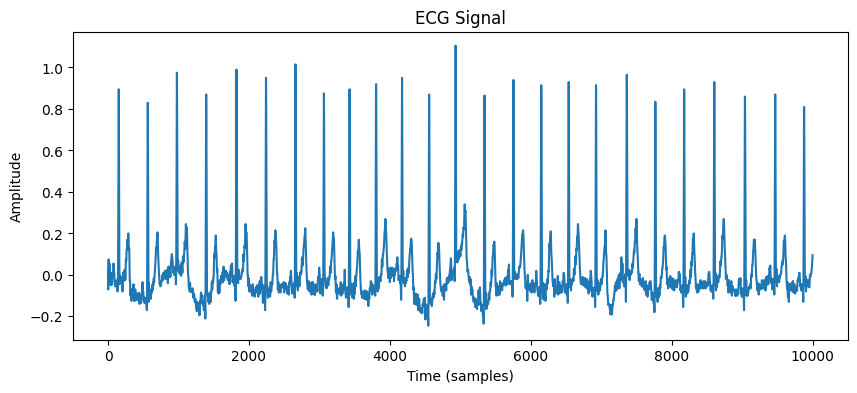

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

In [31]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
# hr2 = pd.read_csv("file_resource/ecg-id-database-1.0.0/Person_03",names=["hr"])
# print(hr2.head())
# create new datatime index to hr2, every 0.5s

import wfdb
import matplotlib.pyplot as plt

# Specify the path to your downloaded data
path_to_data = 'file_resource/ecg-id-database-1.0.0/Person_03/'

# The record name is the filename without the extension
record_name = 'rec_1'

# Use the 'rdrecord' function to read the ECG data
record = wfdb.rdrecord(f'{path_to_data}/{record_name}')
# Plot the ECG data
plt.figure(figsize=(10, 4))
plt.plot(record.p_signal[:,1])
plt.title('ECG Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()
pd.DataFrame(record.p_signal[:,1],columns=["hr"]).to_csv("./P3_rec_1.csv")
hr2 = pd.DataFrame(record.p_signal[:,1],columns=["hr"])[0:10000]



plt.figure(figsize=(10, 4))



In [32]:

from torch import nn
import pandas as pd
import numpy as np
import torch
# X = [x for x in range(10000)]
# hr2_train = hr2[:8000]
# hr2_test = hr2[8000:9000]
# hr2_val = hr2[9000:]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# # hr2[0:800].plot()
# train_X = X[:8000]
# test_X = X[8000:9000]
# val_X = X[9000:]
# hr2_train_y = hr2[:8000]
# hr2_test_y = hr2[8000:9000]
# hr2_val_y = hr2[9000:]
df = hr2.copy()
df_train = df.loc[:8000].copy()
df_test = df.loc[8000:10000].copy()

target_sensor = "hr"
# features = list(df.columns.difference([target_sensor]))
features = ["hr"]
batch_size =5
forecast_lead = 50
target = f"{target_sensor}_lead{forecast_lead}"

df[target] = df[target_sensor].shift(-forecast_lead)
df = df.iloc[:-forecast_lead]

df_train = df.loc[:8000].copy()
df_test = df.loc[8000:].copy()

print("Test set fraction:", len(df_train) / len(df_test))

target_mean = df_train[target].mean()
target_stdev = df_train[target].std()
for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

Test set fraction: 4.103076923076923


In [33]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]

        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)


        return x.to(device), self.y[i].to(device)



train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=forecast_lead
)




In [34]:
# X, y = train_dataset[i + 1]

# print(X)

In [35]:
# print(df_train[features].iloc[(i - sequence_length + 1): (i + 1)])


In [36]:
from torch.utils.data import DataLoader
torch.manual_seed(99)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

X, y = next(iter(train_loader))
print(X.shape)
print(X)

torch.Size([5, 50, 1])
tensor([[[-0.4236],
         [-0.4558],
         [-0.4558],
         [-0.4881],
         [-0.4881],
         [-0.4881],
         [-0.4881],
         [-0.4881],
         [-0.4881],
         [-0.4881],
         [-0.4881],
         [-0.4881],
         [-0.4881],
         [-0.4881],
         [-0.5203],
         [-0.5203],
         [-0.5525],
         [-0.5847],
         [-0.5847],
         [-0.6170],
         [-0.6492],
         [-0.6492],
         [-0.6814],
         [-0.6492],
         [-0.6492],
         [-0.6170],
         [-0.5847],
         [-0.5525],
         [-0.5203],
         [-0.5203],
         [-0.5203],
         [-0.5203],
         [-0.5203],
         [-0.5203],
         [-0.5203],
         [-0.5203],
         [-0.4881],
         [-0.4881],
         [-0.4558],
         [-0.4236],
         [-0.3914],
         [-0.3914],
         [-0.4236],
         [-0.4558],
         [-0.4881],
         [-0.5203],
         [-0.5525],
         [-0.5525],
         [-0.5525

In [37]:
torch.manual_seed(101)


train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=forecast_lead
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=forecast_lead
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([5, 50, 1])
Target shape: torch.Size([5])


In [38]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        ).cuda()

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_().to(device)

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out
    
class ShallowRegressionRNN(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.rnn = nn.RNN(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, hn = self.rnn(x, h0)
        out = self.linear(hn).flatten()

        return out

In [39]:

num_hidden_units = 128
# loss_function = nn.MSELoss()
model_lstm = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

loss_function = RMSELoss()


In [40]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.to(device)
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss


print("Untrained test\n--------")
# test_model(test_loader, model, loss_function)

avg_loss = 1
model_lstm.to(device)

Untrained test
--------


In [82]:
learning_rate = 1e-4

optimizer = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)
for ix_epoch in range(150):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model_lstm, loss_function, optimizer=optimizer)
    temp = test_model(test_loader, model_lstm, loss_function)
    if temp < avg_loss:
        avg_loss = temp
        torch.save(model_lstm.state_dict(), "model_lstm.pt")
    print()

Epoch 0
---------
Train loss: 0.4060327878767516
Test loss: 0.38357305717296325

Epoch 1
---------
Train loss: 0.39044725773931666
Test loss: 0.3713582907349635

Epoch 2
---------
Train loss: 0.38895480311839264
Test loss: 0.3839060643496804

Epoch 3
---------
Train loss: 0.38292269923169864
Test loss: 0.3950677846438992

Epoch 4
---------
Train loss: 0.3842999895291169
Test loss: 0.40853017115344603

Epoch 5
---------
Train loss: 0.37317632393054034
Test loss: 0.3808990539720234

Epoch 6
---------
Train loss: 0.374244271911946
Test loss: 0.3738509850266079

Epoch 7
---------
Train loss: 0.3706506593775314
Test loss: 0.3927115999783079

Epoch 8
---------
Train loss: 0.36671617750001656
Test loss: 0.4238207420692421

Epoch 9
---------
Train loss: 0.3594748887706369
Test loss: 0.3936678028426682

Epoch 10
---------
Train loss: 0.35749692873776817
Test loss: 0.3998688538773702

Epoch 11
---------
Train loss: 0.35420957624069943
Test loss: 0.3982771510377717

Epoch 12
---------
Train loss:

In [81]:
# save the model
# torch.save(model_lstm.state_dict(), "model_lstm.pt")

model_lstm.load_state_dict(torch.load("model_lstm.pt"))

<All keys matched successfully>

In [76]:
def predict(data_loader, model):

    output = torch.tensor([]).to(device)
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            # print(X)
            y_star = model(X)
            # print(y_star)

            output = torch.cat((output, y_star), 0)
            # print(output)
            # break
    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
model_lstm.to(device)
ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model_lstm).cpu().numpy()
df_test[ystar_col] = predict(test_loader, model_lstm).cpu().numpy()



df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)


      hr_lead50  Model forecast
0        -0.005        0.064964
1         0.000        0.059698
2        -0.005        0.050061
3        -0.015        0.038332
4        -0.030        0.028281
...         ...             ...
9945      0.065       -0.003672
9946      0.070        0.007661
9947      0.080        0.026826
9948      0.085        0.040244
9949      0.095        0.050181

[9951 rows x 2 columns]


0 50
5 50
10 50
15 50
20 50
25 50
30 50
35 50
40 50
45 50
50 50
51 50
52 50
53 50
54 50
55 50
56 50
57 50
58 50
59 50
60 50
61 50
62 50
63 50
64 50
65 50
66 50
67 50
68 50
69 50
70 50
71 50
72 50
73 50
74 50
75 50
76 50
77 50
78 50
79 50
80 50
81 50
82 50
83 50
84 50
85 50
86 50
87 50
88 50
89 50
90 50
91 50
92 50
93 50
94 50
95 50
96 50
97 50
98 50
99 50
100 50
101 50
102 50
103 50
104 50
105 50
106 50
107 50
108 50
109 50
110 50
111 50
112 50
113 50
114 50
115 50
116 50
117 50
118 50
119 50
120 50
121 50
122 50
123 50
124 50
125 50
126 50
127 50
128 50
129 50
130 50
131 50
132 50
133 50
134 50
135 50
136 50
137 50
138 50
139 50
140 50
141 50
142 50
143 50
144 50
145 50
146 50
147 50
148 50
149 50
150 50
151 50
152 50
153 50
154 50
155 50
156 50
157 50
158 50
159 50
160 50
161 50
162 50
163 50
164 50
165 50
166 50
167 50
168 50
169 50
170 50
171 50
172 50
173 50
174 50
175 50
176 50
177 50
178 50
179 50
180 50
181 50
182 50
183 50
184 50
185 50
186 50
187 50
188 50
189 50
190 50
191 5

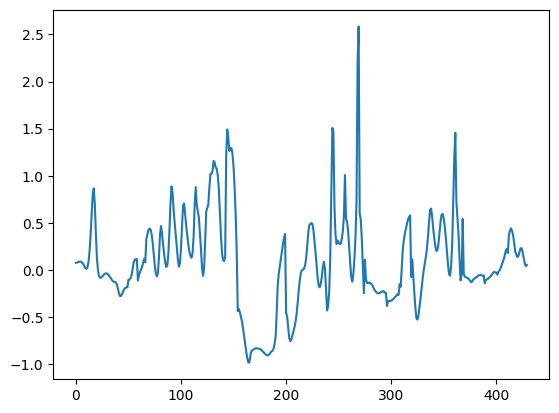

In [77]:
# use last predict data to be the next input
def predict_window(data_loader, model):
    output = torch.tensor([]).to(device)
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            print(output.shape[0],X.shape[1])
            if output.shape[0] >= X.shape[1]:
                y_star = model(output[output.shape[0]-forecast_lead:].reshape(1,forecast_lead,1))
                output = torch.cat((output, y_star), 0)
                continue
            y_star = model(X)
            # print(y_star)
            output = torch.cat((output, y_star), 0)
            # print(output)
            # break
    return output
res = predict_window(test_loader, model_lstm).cpu().numpy()
print(res)
plt.plot(res)

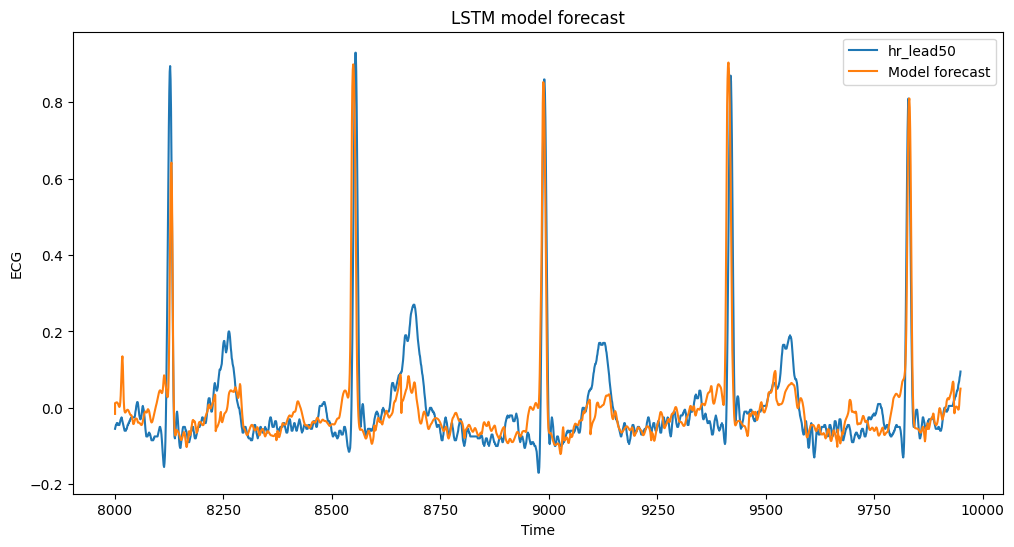

In [78]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_absolute_percentage_error
fig, ax = plt.subplots(figsize=(12, 6))
df_out[8000:].plot(ax=ax)
ax.set_title("LSTM model forecast")
ax.set_ylabel("ECG")
ax.set_xlabel("Time")
plt.show()

In [57]:
# calculate the  error
# calculate the  AIC
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_absolute_percentage_error

def calculate_aic(y_true, y_pred, num_params):
    mse = mean_squared_error(y_true, y_pred)
    aic = len(y_true) * np.log(mse) + 2 * num_params
    return aic

mse = mean_squared_error(df_out[target], df_out[ystar_col])
mae = mean_absolute_error(df_out[target], df_out[ystar_col])
r2 = r2_score(df_out[target], df_out[ystar_col])
mape = mean_absolute_percentage_error(df_out[target], df_out[ystar_col])
print(f"R2: {r2:.6f}")
print(f"MAPE: {mape:.6f}")
print(f"MAE: {mae:.6f} ")
print(f"RMSE: {np.sqrt(mse):.6f}")
print(f"mse: {mse:.6f}")
print(f"AIC: {calculate_aic(df_out[target], df_out[ystar_col], 1):.6f}")

R2: 0.714475
MAPE: 2686135890309.195801
MAE: 0.050537 
RMSE: 0.081493
mse: 0.006641
AIC: -49896.961889


In [ ]:
num_hidden_units = 128
# use sdg loss
# loss_function = nn.MSELoss()
model = ShallowRegressionRNN(num_sensors=len(features), hidden_units=num_hidden_units)
avg_loss = 1
loss_function = RMSELoss()

In [ ]:
learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for ix_epoch in range(200):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    temp = test_model(test_loader, model, loss_function)
    if temp < avg_loss:
        avg_loss = temp
        torch.save(model.state_dict(), "model_RNN.pt")
    print()

In [ ]:
# save the model
# torch.save(model.state_dict(), "model_RNN.pt")

# load the model
model.load_state_dict(torch.load("model_RNN.pt"))
print(avg_loss)

In [ ]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
df_out[8000:].plot(ax=ax)
ax.set_title("RNN model forecast")
ax.set_ylabel("ECG")
ax.set_xlabel("Time")
plt.show()
from sklearn.metrics import mean_absolute_error, mean_squared_error

mse = mean_squared_error(df_out[target], df_out[ystar_col])
mae = mean_absolute_error(df_out[target], df_out[ystar_col])
mape = mean_absolute_percentage_error(df_out[target], df_out[ystar_col])
r2=r2_score(df_out[target], df_out[ystar_col])
print(f"MAE: {mae:.6f} deg C")
print(f"mse: {mse:.6f} deg C")
print(f"MAPE: {mape:.6f}")
print(f"R2: {r2:.6f}")
# aic_res = calaic(df_out[target], df_out[ystar_col], df_out.shape[1])
# print(f"AIC: {aic_res:.6f}")